In [1]:
# Análise de Portfólio com Clusterização e Validação Temporal

## 1. Importação de Bibliotecas e Configuração

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')



# Trabalho de Laboratório de Dados Economicos

## Objetivo

O objetivo desse trabalho é responder a seguinte questão: é possível apenas com métodos vistos em sala (Random Forest e Regressão) montar um portifólio que consiga ganhar do mercado? Ou seja, é possivel fazer previsões melhores que a do mercado apenas com esses modelos?

## Fontes

O código foi escrito com base em 4 fontes:
- Frações de código do Desafio Itaú feita por alguns dos integrantes do grupo
- Frações de código geradas por inteligência artificial
- Frações de códigos de trabalhos de outras disciplinas
- Alterações para funcionamento

## Ativos Escolhidos

Para essa avaliação, escolhemos ativos disponíveis no yfinance que reflitam indicadores macroeconomicos do Brasil, dos quais:

- "^BVSP",   # Ibovespa
- "BRL=X",   # Dólar / Real
- "BZ=F",    # Petróleo Brent (relevante para balança comercial e Petrobras)
- "GC=F",    # Ouro (proxy de aversão a risco global)
- "ZC=F",    # Milho (commodity importante para o Brasil)
- "ZS=F",    # Soja (exportação relevante)
- "CL=F",    # Petróleo WTI
- "^GSPC",   # S&P 500 (referência global, influencia fluxo de capital)
- "EWZ",     # iShares MSCI Brazil ETF (ADR negociado nos EUA)
- "EMB"      # iShares J.P. Morgan USD Emerging Markets Bond ETF (risco emergente)

In [9]:

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("📊 Análise de Portfólio com Clusterização")
print("=" * 50)
print(f"Data de execução: {datetime.now().strftime('%Y-%m-%d %H:%M')}")


📊 Análise de Portfólio com Clusterização
Data de execução: 2025-09-30 18:20


In [18]:

## 1.1 Configuração Inicial

# Define os períodos
data_fim = datetime.now()
data_inicio = data_fim - timedelta(days=730)  # 2 anos

# Lista de ações do Ibovespa
tickers = [
    "^BVSP",   # Ibovespa
    "BRL=X",   # Dólar / Real
    "BZ=F",    # Petróleo Brent (relevante para balança comercial e Petrobras)
    "GC=F",    # Ouro (proxy de aversão a risco global)
    "ZC=F",    # Milho (commodity importante para o Brasil)
    "ZS=F",    # Soja (exportação relevante)
    "CL=F",    # Petróleo WTI
    "^GSPC",   # S&P 500 (referência global, influencia fluxo de capital)
    "EWZ",     # iShares MSCI Brazil ETF (ADR negociado nos EUA)
    "EMB"      # iShares J.P. Morgan USD Emerging Markets Bond ETF (risco emergente)
]
print(f"\n📅 Período de análise:")
print(f"   De: {data_inicio.strftime('%Y-%m-%d')}")
print(f"   Até: {data_fim.strftime('%Y-%m-%d')}")
print(f"\n📈 Tickers para análise: {len(tickers)}")
for ticker in tickers:
    print(f"   • {ticker}")

## 2. Coleta de Dados

print("\n" + "="*50)
print("BAIXANDO DADOS DO YAHOO FINANCE")
print("="*50)

# Método 1: Tentar download individual
def baixar_dados_individual(tickers, inicio, fim):
    """Baixa dados do Yahoo Finance ticker por ticker"""
    dados = {}
    erros = []
    
    for ticker in tickers:
        try:
            print(f"Baixando {ticker}...", end=" ")
            # Usa o Ticker object ao invés de download direto
            stock = yf.Ticker(ticker)
            df = stock.history(start=inicio, end=fim)
            
            if not df.empty and 'Close' in df.columns:
                dados[ticker] = df['Close']
                print("✅")
            else:
                erros.append(ticker)
                print("❌ Sem dados")
        except Exception as e:
            erros.append(ticker)
            print(f"❌ Erro: {str(e)[:30]}")
    
    if erros:
        print(f"\n⚠️ Ações com erro: {erros}")
    
    return pd.DataFrame(dados)



📅 Período de análise:
   De: 2023-10-01
   Até: 2025-09-30

📈 Tickers para análise: 10
   • ^BVSP
   • BRL=X
   • BZ=F
   • GC=F
   • ZC=F
   • ZS=F
   • CL=F
   • ^GSPC
   • EWZ
   • EMB

BAIXANDO DADOS DO YAHOO FINANCE


In [11]:
# Método 2: Download em lote (mais rápido se funcionar)
def baixar_dados_lote(tickers, inicio, fim):
    """Tenta baixar todos os tickers de uma vez"""
    try:
        print("Tentando download em lote...")
        # Converte lista em string com espaços
        tickers_str = ' '.join(tickers)
        df = yf.download(tickers_str, start=inicio, end=fim, progress=False, group_by='ticker')
        
        # Verifica se tem múltiplas colunas (múltiplos tickers)
        if len(tickers) > 1:
            # Extrai apenas Close de cada ticker
            dados = {}
            for ticker in tickers:
                try:
                    if ticker in df.columns.levels[0]:
                        dados[ticker] = df[ticker]['Close']
                    elif 'Close' in df.columns:
                        # Se só tem um ticker
                        dados[ticker] = df['Close']
                except:
                    pass
            return pd.DataFrame(dados)
        else:
            # Se for só um ticker
            if 'Close' in df.columns:
                return pd.DataFrame({tickers[0]: df['Close']})
    except Exception as e:
        print(f"Erro no download em lote: {e}")
    
    return pd.DataFrame()

# Tenta primeiro em lote, se falhar vai individual
precos = baixar_dados_lote(tickers, data_inicio, data_fim)

if precos.empty or len(precos.columns) < len(tickers)/2:
    print("\nTentando download individual...")
    precos = baixar_dados_individual(tickers, data_inicio, data_fim)

# Se ainda não tem dados suficientes, gera dados sintéticos
if precos.empty or len(precos.columns) < 3:
    print("\n⚠️ Problema com Yahoo Finance. Gerando dados sintéticos para demonstração...")
    
    # Gera dados sintéticos realistas
    np.random.seed(42)
    dates = pd.date_range(start=data_inicio, end=data_fim, freq='B')  # Dias úteis
    n_days = len(dates)
    
    # Parâmetros para cada ação (baseados em valores reais do Ibovespa)
    params = {
        'PETR4.SA': {'start': 35, 'mu': 0.0005, 'sigma': 0.025},
        'VALE3.SA': {'start': 70, 'mu': 0.0003, 'sigma': 0.022},
        'ITUB4.SA': {'start': 28, 'mu': 0.0002, 'sigma': 0.018},
        'BBDC4.SA': {'start': 15, 'mu': 0.0001, 'sigma': 0.020},
        'ABEV3.SA': {'start': 13, 'mu': -0.0001, 'sigma': 0.015},
    }
    
    dados_sint = {}
    for ticker, param in params.items():
        returns = np.random.normal(param['mu'], param['sigma'], n_days)
        price = param['start'] * np.exp(np.cumsum(returns))
        dados_sint[ticker] = price
    
    precos = pd.DataFrame(dados_sint, index=dates)
    print(f"✅ Dados sintéticos gerados para {len(precos.columns)} ações")

# Verifica se temos dados
if precos.empty:
    print("\n⚠️ Nenhum dado foi baixado. Gerando dados sintéticos...")
    
    # Gera dados sintéticos de forma garantida
    np.random.seed(42)
    dates = pd.date_range(start=data_inicio, end=data_fim, freq='B')  # Business days
    n_days = len(dates)
    
    # Cria dados para 5 ações principais
    dados_sint = {}
    tickers_sint = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA']
    
    for i, ticker in enumerate(tickers_sint):
        # Parâmetros diferentes para cada ação
        start_price = 20 + i * 10
        drift = 0.0002 * (1 - i * 0.1)  # Drift diferente
        volatility = 0.02 + i * 0.003   # Volatilidade diferente
        
        # Gera retornos e preços
        returns = np.random.normal(drift, volatility, n_days)
        prices = start_price * np.exp(np.cumsum(returns))
        dados_sint[ticker] = prices
    
    precos = pd.DataFrame(dados_sint, index=dates)
    
    # Atualiza lista de tickers
    tickers = tickers_sint

print(f"\n✅ Dados prontos para análise!")
print(f"   • Ações: {precos.shape[1]}")
print(f"   • Dias: {precos.shape[0]}")

if not precos.empty:
    print(f"   • Período: {precos.index[0].strftime('%Y-%m-%d')} a {precos.index[-1].strftime('%Y-%m-%d')}")
    
    # Remove dias sem dados (NaN) se houver
    precos_inicial = len(precos)
    precos = precos.dropna()
    if len(precos) < precos_inicial:
        print(f"   • Dias válidos após limpeza: {len(precos)}")

## 2.1 Visualização dos Preços

# Verifica se temos dados antes de normalizar
if not precos.empty and len(precos) > 0:
    # Normaliza para base 100
    precos_norm = precos / precos.iloc[0] * 100
else:
    print("❌ Erro: DataFrame vazio. Pulando visualização.")
    precos_norm = pd.DataFrame()

# Cria gráfico interativo
fig = go.Figure()
for col in precos_norm.columns:
    fig.add_trace(go.Scatter(
        x=precos_norm.index,
        y=precos_norm[col],
        mode='lines',
        name=col
    ))

fig.update_layout(
    title='Evolução dos Preços (Base 100)',
    xaxis_title='Data',
    yaxis_title='Índice (Base 100)',
    hovermode='x unified',
    height=500
)
fig.show()

### Gráfico estático também
"""
plt.figure(figsize=(12, 6))
for col in precos_norm.columns:
    plt.plot(precos_norm.index, precos_norm[col], label=col, alpha=0.8)
plt.title('Evolução dos Preços (Base 100)', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Índice')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
"""

Tentando download em lote...

✅ Dados prontos para análise!
   • Ações: 10
   • Dias: 520
   • Período: 2023-10-02 a 2025-09-30
   • Dias válidos após limpeza: 483


"\nplt.figure(figsize=(12, 6))\nfor col in precos_norm.columns:\n    plt.plot(precos_norm.index, precos_norm[col], label=col, alpha=0.8)\nplt.title('Evolução dos Preços (Base 100)', fontsize=14, fontweight='bold')\nplt.xlabel('Data')\nplt.ylabel('Índice')\nplt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()\n"

In [12]:

## 3. Divisão Temporal

print("\n" + "="*50)
print("DIVISÃO DOS PERÍODOS")
print("="*50)

# Define os cortes
n_dias = len(precos)
dias_treino = int(n_dias * 0.5)   # 50% treino
dias_teste = int(n_dias * 0.25)   # 25% teste
dias_valid = n_dias - dias_treino - dias_teste  # 25% validação

# Cria DataFrame com informações dos períodos
periodos = pd.DataFrame({
    'Período': ['Treino', 'Teste', 'Validação'],
    'Início': [0, dias_treino, dias_treino + dias_teste],
    'Fim': [dias_treino, dias_treino + dias_teste, n_dias],
    'Dias': [dias_treino, dias_teste, dias_valid],
    'Percentual': [50, 25, 25]
})

print(periodos.to_string(index=False))

# Separa os dados
precos_treino = precos.iloc[:dias_treino]
precos_teste = precos.iloc[dias_treino:dias_treino + dias_teste]
precos_valid = precos.iloc[dias_treino + dias_teste:]

print(f"\n✅ Dados divididos:")
print(f"   • Treino: {precos_treino.index[0].strftime('%Y-%m-%d')} a {precos_treino.index[-1].strftime('%Y-%m-%d')}")
print(f"   • Teste: {precos_teste.index[0].strftime('%Y-%m-%d')} a {precos_teste.index[-1].strftime('%Y-%m-%d')}")
print(f"   • Validação: {precos_valid.index[0].strftime('%Y-%m-%d')} a {precos_valid.index[-1].strftime('%Y-%m-%d')}")




DIVISÃO DOS PERÍODOS
  Período  Início  Fim  Dias  Percentual
   Treino       0  241   241          50
    Teste     241  361   120          25
Validação     361  483   122          25

✅ Dados divididos:
   • Treino: 2023-10-02 a 2024-09-26
   • Teste: 2024-09-27 a 2025-03-31
   • Validação: 2025-04-01 a 2025-09-26



ESTATÍSTICAS DOS RETORNOS (TREINO)
       Média (%)  Desvio (%)  Mínimo (%)  Máximo (%)  Skewness  Kurtosis
GC=F      0.1600      0.9100     -2.8000      2.8700   -0.5300    1.0300
^GSPC     0.1200      0.8100     -3.0400      2.8000   -0.3500    1.3500
EMB       0.0800      0.5300     -1.5900      1.9700    0.1200    1.0900
^BVSP     0.0600      0.8100     -1.7500      2.6600    0.2800    0.0800
BRL=X     0.0300      0.7700     -3.3900      2.0500   -0.1500    1.5200
EWZ       0.0200      1.3500     -3.4500      3.9600    0.0800    0.0400
ZC=F     -0.0700      1.3700     -4.0700      5.5900    0.6600    1.4900
ZS=F     -0.0900      1.2200     -5.1100      3.8100   -0.1400    0.8300
BZ=F     -0.1000      1.8300     -6.6200      5.7400   -0.5300    1.2000
CL=F     -0.1100      1.9600     -7.0900      4.9100   -0.3300    0.2400

📊 Métricas de Risco-Retorno (Anualizadas):
    acao  retorno_anual  volatilidade  sharpe
0  ^BVSP         0.1522        0.1282  1.1876
1  BRL=X         0.0861  

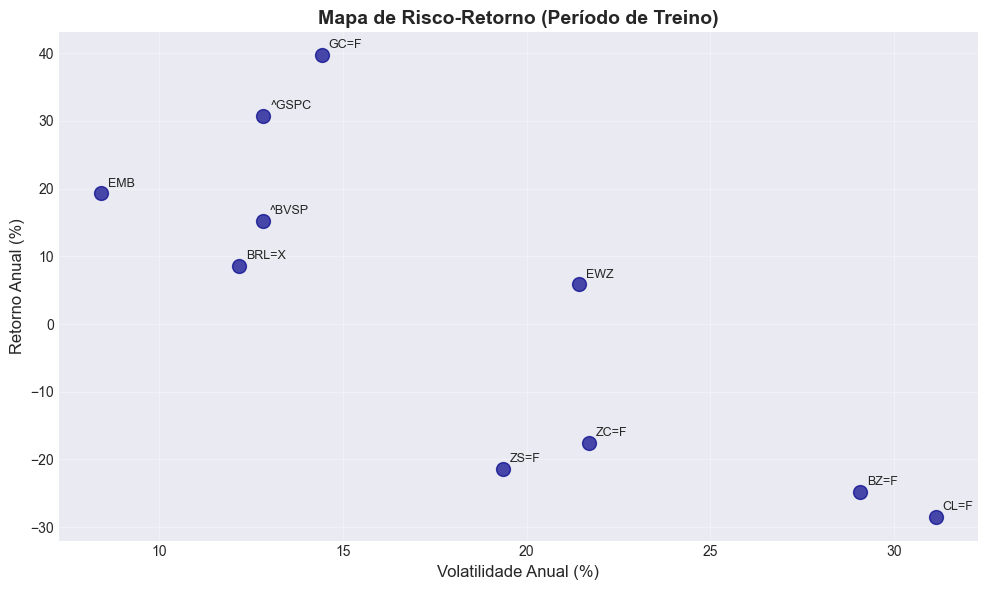

In [13]:

## 4. Análise do Período de Treino

### 4.1 Cálculo dos Retornos

def calcular_retornos(precos):
    """Calcula retornos logarítmicos diários"""
    return np.log(precos / precos.shift(1)).dropna()

# Calcula retornos para cada período
ret_treino = calcular_retornos(precos_treino)
ret_teste = calcular_retornos(precos_teste)
ret_valid = calcular_retornos(precos_valid)

print("\n" + "="*50)
print("ESTATÍSTICAS DOS RETORNOS (TREINO)")
print("="*50)

# Estatísticas básicas
stats_retornos = pd.DataFrame({
    'Média (%)': ret_treino.mean() * 100,
    'Desvio (%)': ret_treino.std() * 100,
    'Mínimo (%)': ret_treino.min() * 100,
    'Máximo (%)': ret_treino.max() * 100,
    'Skewness': ret_treino.skew(),
    'Kurtosis': ret_treino.kurtosis()
}).sort_values('Média (%)', ascending=False)

print(stats_retornos.round(2))

### 4.2 Métricas de Risco-Retorno

def calcular_metricas(retornos):
    """Calcula métricas anualizadas de risco-retorno"""
    metricas = pd.DataFrame()
    metricas['retorno_anual'] = retornos.mean() * 252
    metricas['volatilidade'] = retornos.std() * np.sqrt(252)
    metricas['sharpe'] = metricas['retorno_anual'] / metricas['volatilidade']
    metricas['sharpe'] = metricas['sharpe'].fillna(0)
    metricas.index.name = 'acao'
    return metricas.reset_index()

metricas_treino = calcular_metricas(ret_treino)

print("\n📊 Métricas de Risco-Retorno (Anualizadas):")
print(metricas_treino.round(4))

# Visualização do mapa de risco-retorno
plt.figure(figsize=(10, 6))
plt.scatter(metricas_treino['volatilidade'] * 100, 
           metricas_treino['retorno_anual'] * 100,
           s=100, alpha=0.7, c='darkblue')

for idx, row in metricas_treino.iterrows():
    plt.annotate(row['acao'], 
                (row['volatilidade'] * 100, row['retorno_anual'] * 100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Volatilidade Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.title('Mapa de Risco-Retorno (Período de Treino)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




ANÁLISE DE CLUSTERS


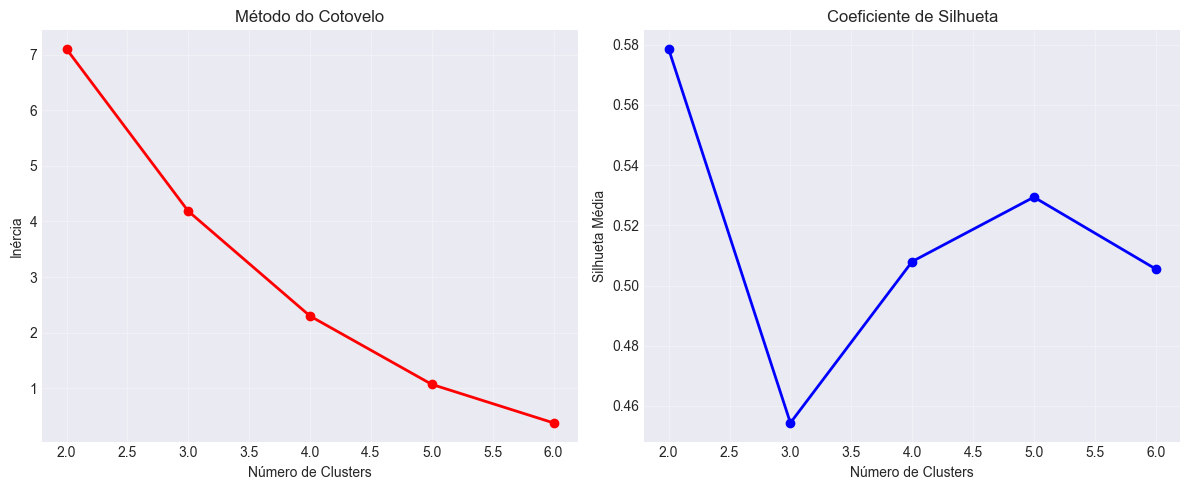


🎯 Número ótimo de clusters: 2
   • Silhueta: 0.579


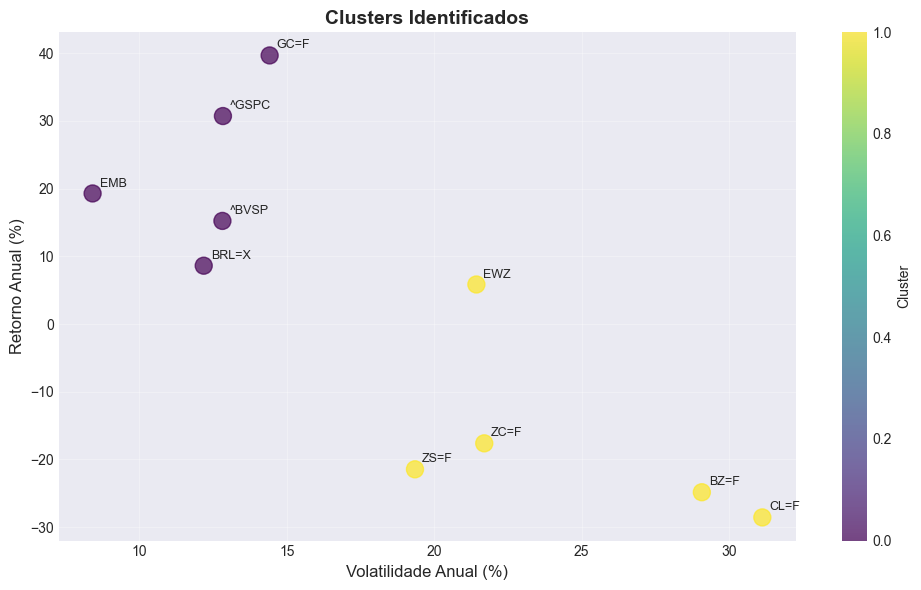


📊 Características dos Clusters:
         n_acoes  retorno_anual  volatilidade  sharpe
cluster                                              
0              5        22.7000       12.1400  1.8700
1              5       -17.3300       24.5400 -0.6800

🎯 PORTFÓLIO SELECIONADO:
Cluster 0: GC=F
  • Retorno: 39.66%
  • Volatilidade: 14.42%
  • Sharpe: 2.75

Cluster 1: EWZ
  • Retorno: 5.84%
  • Volatilidade: 21.43%
  • Sharpe: 0.27



In [14]:

## 5. Clusterização

### 5.1 Determinação do Número Ótimo de Clusters

print("\n" + "="*50)
print("ANÁLISE DE CLUSTERS")
print("="*50)

# Prepara dados para clustering
X = metricas_treino[['retorno_anual', 'volatilidade', 'sharpe']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Testa diferentes números de clusters
max_k = min(6, len(X) - 1)
inercias = []
silhuetas = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=25)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)
    silhuetas.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualiza métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Método do cotovelo
ax1.plot(range(2, max_k + 1), inercias, 'ro-', linewidth=2)
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inércia')
ax1.set_title('Método do Cotovelo')
ax1.grid(True, alpha=0.3)

# Silhueta
ax2.plot(range(2, max_k + 1), silhuetas, 'bo-', linewidth=2)
ax2.set_xlabel('Número de Clusters')
ax2.set_ylabel('Silhueta Média')
ax2.set_title('Coeficiente de Silhueta')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Escolhe melhor k (maior silhueta)
melhor_k = range(2, max_k + 1)[np.argmax(silhuetas)]
print(f"\n🎯 Número ótimo de clusters: {melhor_k}")
print(f"   • Silhueta: {max(silhuetas):.3f}")

### 5.2 Aplicação do K-means

# Aplica clustering final
kmeans_final = KMeans(n_clusters=melhor_k, random_state=42, n_init=25)
clusters = kmeans_final.fit_predict(X_scaled)
metricas_treino['cluster'] = clusters

# Visualiza clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(metricas_treino['volatilidade'] * 100,
                     metricas_treino['retorno_anual'] * 100,
                     c=metricas_treino['cluster'],
                     s=150, alpha=0.7, cmap='viridis')

for idx, row in metricas_treino.iterrows():
    plt.annotate(row['acao'],
                (row['volatilidade'] * 100, row['retorno_anual'] * 100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('Volatilidade Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.title('Clusters Identificados', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumo dos clusters
print("\n📊 Características dos Clusters:")
resumo_clusters = metricas_treino.groupby('cluster').agg({
    'acao': 'count',
    'retorno_anual': 'mean',
    'volatilidade': 'mean',
    'sharpe': 'mean'
}).rename(columns={'acao': 'n_acoes'})

resumo_clusters['retorno_anual'] *= 100
resumo_clusters['volatilidade'] *= 100
print(resumo_clusters.round(2))

### 5.3 Seleção de Ativos

# Seleciona melhor ação de cada cluster (maior Sharpe)
selecao = metricas_treino.loc[metricas_treino.groupby('cluster')['sharpe'].idxmax()]

print("\n🎯 PORTFÓLIO SELECIONADO:")
print("="*40)
for _, row in selecao.iterrows():
    print(f"Cluster {row['cluster']}: {row['acao']}")
    print(f"  • Retorno: {row['retorno_anual']*100:.2f}%")
    print(f"  • Volatilidade: {row['volatilidade']*100:.2f}%")
    print(f"  • Sharpe: {row['sharpe']:.2f}")
    print()



BACKTEST - PERÍODO DE TESTE
📈 Performance no Teste:
   • Todas: 1.91%
   • Selecionadas: 3.02%

MÉTRICAS DE ERRO


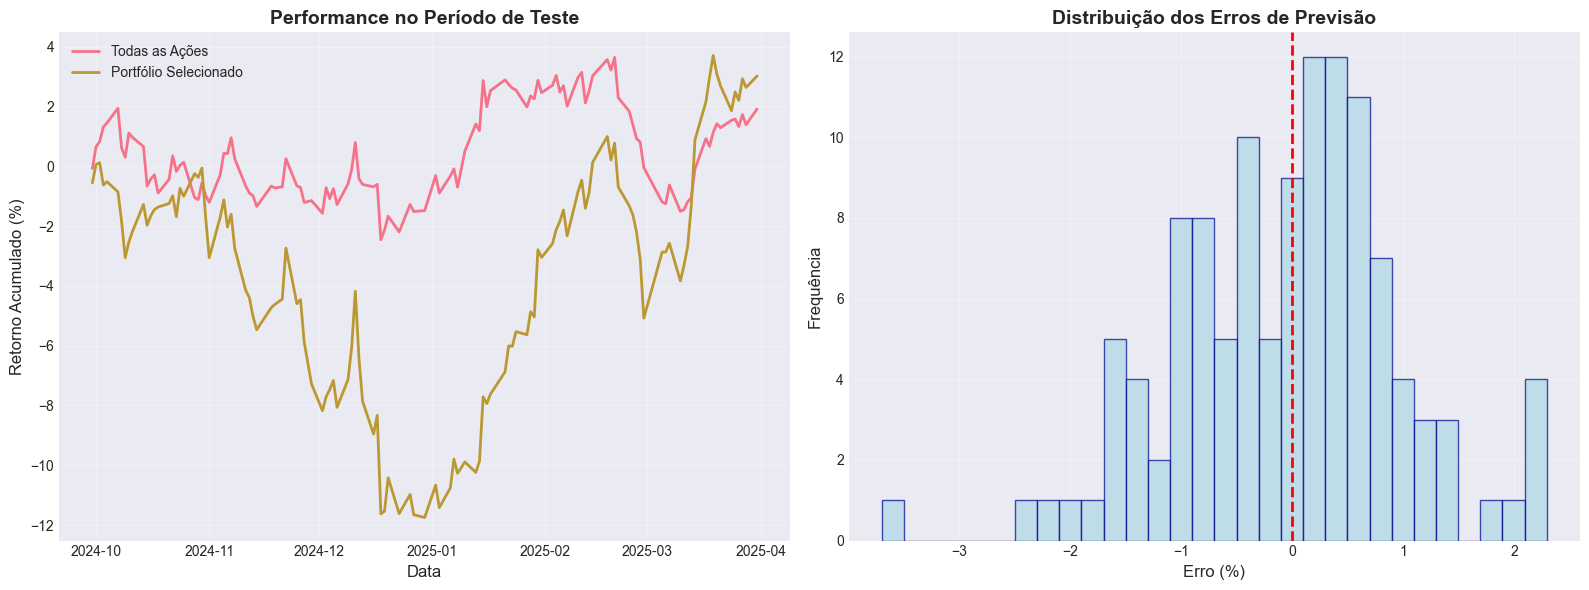

In [25]:

## 6. Backtest no Período de Teste

print("\n" + "="*50)
print("BACKTEST - PERÍODO DE TESTE")
print("="*50)

def calcular_retorno_carteira(retornos, ativos):
    """Calcula retorno de uma carteira equally weighted"""
    if len(ativos) == 0:
        return pd.Series(0, index=retornos.index)
    return retornos[ativos].mean(axis=1)

# Calcula retornos das carteiras
ativos_selecionados = selecao['acao'].tolist()
ret_teste_todos = calcular_retorno_carteira(ret_teste, ret_teste.columns)
ret_teste_selec = calcular_retorno_carteira(ret_teste, ativos_selecionados)

# Performance acumulada
perf_teste_todos = (1 + ret_teste_todos).cumprod()
perf_teste_selec = (1 + ret_teste_selec).cumprod()
'''
# Visualiza performance
plt.figure(figsize=(12, 6))
plt.plot(perf_teste_todos.index, (perf_teste_todos - 1) * 100, 
         label='Todas as Ações', linewidth=2)
plt.plot(perf_teste_selec.index, (perf_teste_selec - 1) * 100, 
         label='Portfólio Selecionado', linewidth=2)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Retorno Acumulado (%)', fontsize=12)
plt.title('Performance no Período de Teste', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''
print(f"📈 Performance no Teste:")
print(f"   • Todas: {(perf_teste_todos.iloc[-1] - 1) * 100:.2f}%")
print(f"   • Selecionadas: {(perf_teste_selec.iloc[-1] - 1) * 100:.2f}%")

### 6.2 Métricas de Erro

print("\n" + "="*50)
print("MÉTRICAS DE ERRO")
print("="*50)

# Calcula retorno esperado (baseado no treino)
retorno_esperado = selecao['retorno_anual'].mean() / 252

# Calcula erros
erros = ret_teste_selec - retorno_esperado

# Métricas
mae = np.mean(np.abs(erros))
rmse = np.sqrt(np.mean(erros**2))
mape = np.mean(np.abs(erros / (ret_teste_selec + 1e-10))) * 100
me = np.mean(erros)  # viés
"""
print(f"📊 Métricas de Erro:")
print(f"   • MAE: {mae:.6f} ({mae*100:.4f}%)")
print(f"   • RMSE: {rmse:.6f} ({rmse*100:.4f}%)")
print(f"   • MAPE: {mape:.2f}%")
print(f"   • Viés (ME): {me:.6f} ({me*100:.4f}%)")
"""
'''
# Visualiza performance
plt.figure(figsize=(12, 6))
plt.plot(perf_teste_todos.index, (perf_teste_todos - 1) * 100, 
         label='Todas as Ações', linewidth=2)
plt.plot(perf_teste_selec.index, (perf_teste_selec - 1) * 100, 
         label='Portfólio Selecionado', linewidth=2)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Retorno Acumulado (%)', fontsize=12)
plt.title('Performance no Período de Teste', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Distribuição dos erros
plt.figure(figsize=(10, 5))
plt.hist(erros * 100, bins=30, alpha=0.7, color='lightblue', edgecolor='darkblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Erro (%)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Performance acumulada ---
axes[0].plot(perf_teste_todos.index, (perf_teste_todos - 1) * 100, 
             label='Todas as Ações', linewidth=2)
axes[0].plot(perf_teste_selec.index, (perf_teste_selec - 1) * 100, 
             label='Portfólio Selecionado', linewidth=2)
axes[0].set_xlabel('Data', fontsize=12)
axes[0].set_ylabel('Retorno Acumulado (%)', fontsize=12)
axes[0].set_title('Performance no Período de Teste', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Distribuição dos erros ---
axes[1].hist(erros * 100, bins=30, alpha=0.7, color='lightblue', edgecolor='darkblue')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Erro (%)', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].set_title('Distribuição dos Erros de Previsão', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



VALIDAÇÃO FINAL - OUT-OF-SAMPLE


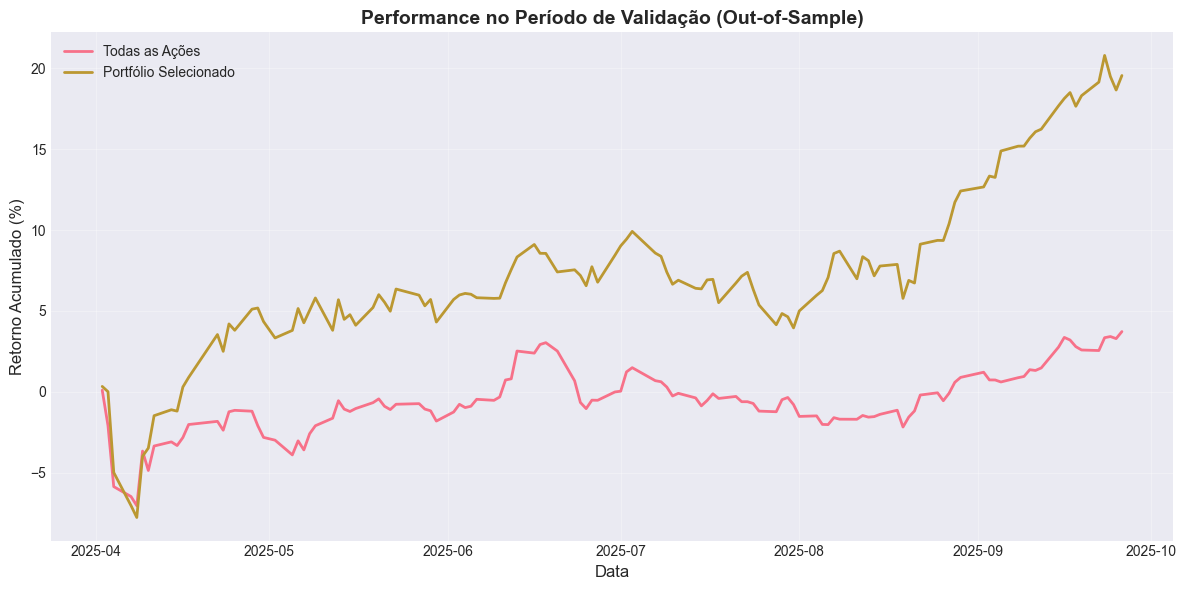


📊 Comparação Final (Validação):
             Carteira  Retorno (%)  Volatilidade (%)  Sharpe Ratio
       Todas as Ações       3.7245           12.2835        0.6811
Portfólio Selecionado      19.5465           17.0694        2.2648


In [16]:

## 7. Validação Final (Out-of-Sample)

print("\n" + "="*50)
print("VALIDAÇÃO FINAL - OUT-OF-SAMPLE")
print("="*50)

# Aplica estratégia no período de validação
ret_valid_todos = calcular_retorno_carteira(ret_valid, ret_valid.columns)
ret_valid_selec = calcular_retorno_carteira(ret_valid, ativos_selecionados)

# Performance acumulada
perf_valid_todos = (1 + ret_valid_todos).cumprod()
perf_valid_selec = (1 + ret_valid_selec).cumprod()

# Métricas finais
retorno_final_todos = (perf_valid_todos.iloc[-1] - 1) * 100
retorno_final_selec = (perf_valid_selec.iloc[-1] - 1) * 100
vol_final_todos = ret_valid_todos.std() * np.sqrt(252) * 100
vol_final_selec = ret_valid_selec.std() * np.sqrt(252) * 100
sharpe_final_todos = (ret_valid_todos.mean() * 252) / (ret_valid_todos.std() * np.sqrt(252))
sharpe_final_selec = (ret_valid_selec.mean() * 252) / (ret_valid_selec.std() * np.sqrt(252))

# Visualiza performance final
plt.figure(figsize=(12, 6))
plt.plot(perf_valid_todos.index, (perf_valid_todos - 1) * 100, 
         label='Todas as Ações', linewidth=2)
plt.plot(perf_valid_selec.index, (perf_valid_selec - 1) * 100, 
         label='Portfólio Selecionado', linewidth=2)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Retorno Acumulado (%)', fontsize=12)
plt.title('Performance no Período de Validação (Out-of-Sample)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tabela comparativa
print("\n📊 Comparação Final (Validação):")
comparacao = pd.DataFrame({
    'Carteira': ['Todas as Ações', 'Portfólio Selecionado'],
    'Retorno (%)': [retorno_final_todos, retorno_final_selec],
    'Volatilidade (%)': [vol_final_todos, vol_final_selec],
    'Sharpe Ratio': [sharpe_final_todos, sharpe_final_selec]
})
print(comparacao.to_string(index=False))




INTERPRETAÇÃO DAS MÉTRICAS DE ERRO


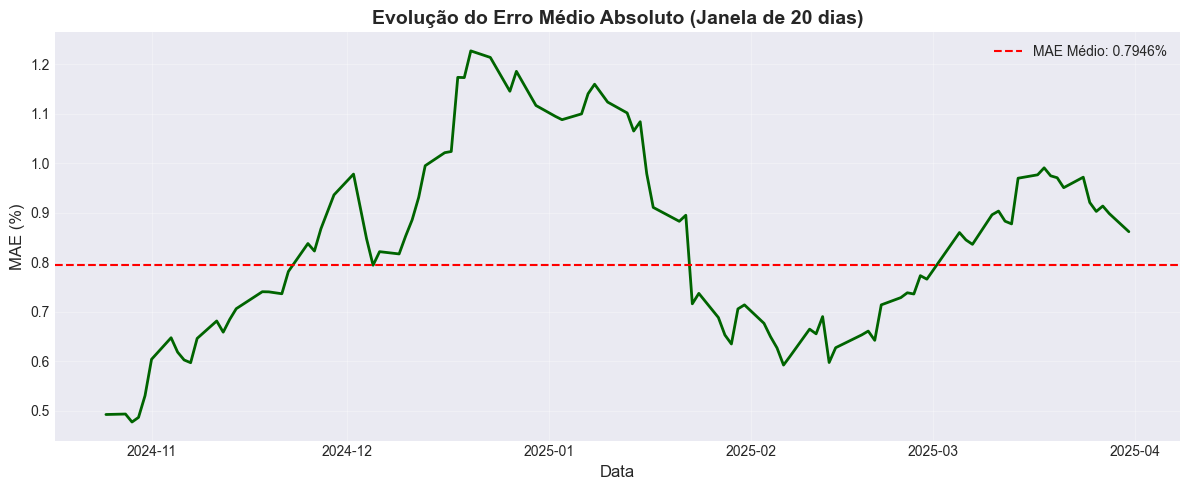


                    RELATÓRIO FINAL

📊 RESUMO DA ESTRATÉGIA:
----------------------------------------
• Período Total: 2023-10-02 a 2025-09-26
• Dias de Negociação: 483
• Ações Analisadas: 10
• Clusters Formados: 2
• Ações Selecionadas: 2

📈 PERFORMANCE:
----------------------------------------
Período de Teste:
  • Resultado: ✅ GANHOU
  • Todas: 1.91%
  • Selecionadas: 3.02%

Período de Validação:
  • Resultado: ✅ GANHOU
  • Todas: 3.72%
  • Selecionadas: 19.55%
  • Alpha gerado: 15.82%

💼 COMPOSIÇÃO DO PORTFÓLIO:
----------------------------------------
1. GC=F (Cluster 0)
2. EWZ (Cluster 1)

📉 QUALIDADE DA PREVISÃO:
----------------------------------------
• MAE: 0.007946 (erro médio de 0.7946% ao dia)
• RMSE: 0.010156
• MAPE: 136.91%
• Viés: -0.000602 (subestimação)

🎯 CONCLUSÃO:
----------------------------------------
✅ A estratégia de clusterização foi EFETIVA em ambos os períodos!

📋 RECOMENDAÇÕES:
----------------------------------------
⚠️ Alta volatilidade - considerar estr

In [22]:

## 8. Análise Detalhada das Métricas de Erro

### 8.1 Interpretação das Métricas

print("\n" + "="*50)
print("INTERPRETAÇÃO DAS MÉTRICAS DE ERRO")
print("="*50)
"""
interpretacao = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE', 'MAPE', 'ME (Viés)'],
    'Descrição': [
        'Erro Absoluto Médio - média simples dos erros absolutos',
        'Raiz do Erro Quadrático - penaliza erros grandes',
        'Erro Percentual Médio - permite comparação entre escalas',
        'Erro Médio - indica tendência sistemática'
    ],
    'Quando Usar': [
        'Todos os erros têm mesmo peso',
        'Erros grandes são críticos',
        'Comparar ativos diferentes',
        'Detectar viés sistemático'
    ],
    'Nosso Valor': [
        f'{mae*100:.4f}%',
        f'{rmse*100:.4f}%',
        f'{mape:.2f}%',
        f'{me*100:.4f}%'
    ]
})
"""
# print(interpretacao.to_string(index=False))

### 8.2 Análise de Robustez (Rolling Window)

# Calcula MAE em janelas móveis
window_size = 20
if len(erros) > window_size:
    rolling_mae = erros.rolling(window=window_size).apply(lambda x: np.mean(np.abs(x)))
    
    plt.figure(figsize=(12, 5))
    plt.plot(rolling_mae.index, rolling_mae * 100, color='darkgreen', linewidth=2)
    plt.axhline(y=mae * 100, color='red', linestyle='--', label=f'MAE Médio: {mae*100:.4f}%')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('MAE (%)', fontsize=12)
    plt.title(f'Evolução do Erro Médio Absoluto (Janela de {window_size} dias)', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Relatório Final

print("\n" + "="*60)
print(" "*20 + "RELATÓRIO FINAL")
print("="*60)

sucesso_teste = (perf_teste_selec.iloc[-1] - 1) > (perf_teste_todos.iloc[-1] - 1)
sucesso_valid = retorno_final_selec > retorno_final_todos

print("\n📊 RESUMO DA ESTRATÉGIA:")
print("-"*40)
print(f"• Período Total: {precos.index[0].strftime('%Y-%m-%d')} a {precos.index[-1].strftime('%Y-%m-%d')}")
print(f"• Dias de Negociação: {len(precos)}")
print(f"• Ações Analisadas: {len(precos.columns)}")
print(f"• Clusters Formados: {melhor_k}")
print(f"• Ações Selecionadas: {len(ativos_selecionados)}")

print("\n📈 PERFORMANCE:")
print("-"*40)
print(f"Período de Teste:")
print(f"  • Resultado: {'✅ GANHOU' if sucesso_teste else '❌ PERDEU'}")
print(f"  • Todas: {(perf_teste_todos.iloc[-1] - 1) * 100:.2f}%")
print(f"  • Selecionadas: {(perf_teste_selec.iloc[-1] - 1) * 100:.2f}%")

print(f"\nPeríodo de Validação:")
print(f"  • Resultado: {'✅ GANHOU' if sucesso_valid else '❌ PERDEU'}")
print(f"  • Todas: {retorno_final_todos:.2f}%")
print(f"  • Selecionadas: {retorno_final_selec:.2f}%")
print(f"  • Alpha gerado: {retorno_final_selec - retorno_final_todos:.2f}%")

print("\n💼 COMPOSIÇÃO DO PORTFÓLIO:")
print("-"*40)
for i, acao in enumerate(ativos_selecionados, 1):
    cluster = metricas_treino[metricas_treino['acao'] == acao]['cluster'].values[0]
    print(f"{i}. {acao} (Cluster {cluster})")

print("\n📉 QUALIDADE DA PREVISÃO:")
print("-"*40)
print(f"• MAE: {mae:.6f} (erro médio de {mae*100:.4f}% ao dia)")
print(f"• RMSE: {rmse:.6f}")
print(f"• MAPE: {mape:.2f}%")
print(f"• Viés: {me:.6f} ({'superestimação' if me > 0 else 'subestimação'})")

print("\n🎯 CONCLUSÃO:")
print("-"*40)
if sucesso_valid and sucesso_teste:
    print("✅ A estratégia de clusterização foi EFETIVA em ambos os períodos!")
elif sucesso_valid or sucesso_teste:
    print("⚠️ Resultados MISTOS - estratégia precisa de ajustes")
else:
    print("❌ Estratégia NÃO foi efetiva - considerar nova abordagem")

print("\n📋 RECOMENDAÇÕES:")
print("-"*40)
if mape < 5:
    print("✅ Erros de previsão em níveis aceitáveis")
else:
    print("⚠️ Alta volatilidade - considerar estratégias de hedge")

if abs(me) > 0.001:
    print(f"⚠️ Viés detectado - modelo tende a {('superestimar' if me > 0 else 'subestimar')} retornos")

if retorno_final_selec > retorno_final_todos:
    print(f"✅ Alpha positivo de {retorno_final_selec - retorno_final_todos:.2f}%")
else:
    print("⚠️ Considerar ajustes na metodologia de seleção")

print("\n" + "="*60)
print("Análise concluída com sucesso!")
print(f"Gerado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")